In [1]:

from network import transformNet
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet,DiscriminatorNet_feature
from functional import noise
#from train import train,eval_generate
import resnet


import invresnet
import matplotlib.pylab as plt

from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim

In [2]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:

%load_ext autoreload
%autoreload 2

In [4]:
train_load,test_load=batchfy(batch_size=256)

In [5]:
show_img=iter(train_load)

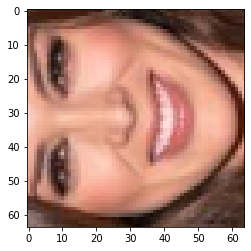

In [6]:
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [7]:
len(train_load)

10

In [8]:
Encoder=resnet.resnet18()
Encoder.to(device)

Decoder=invresnet.invresnet18()
Decoder.to(device)

Generator=GeneratorNet(Encoder,Decoder)
Generator.to(device)
Discriminator_reconstruct=DiscriminatorNet_reconstruction(3,64)
Discriminator_reconstruct.to(device)

Discriminator_feature=DiscriminatorNet_feature()
Discriminator_feature.to(device)
print("model_loaded")

debug=torch.randn((1,99))
debug.to(device)
Decoder(debug).shape

model_loaded


torch.Size([1, 3, 64, 64])

In [9]:
dr_optimizer = optim.Adam(Discriminator_reconstruct.parameters(), lr=0.00005, betas=(0.5, 0.999))
df_optimizer = optim.Adam(Discriminator_feature.parameters(), lr=0.00005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(Generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
e_optimizer = optim.Adam(Encoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(Decoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
#print("modules Loaded")
num_epochs=20

In [10]:
import time
from torchvision import transforms, utils

In [18]:
def real_data_target(size):
    data = torch.ones(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = torch.zeros(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def real_feature_target(size):
    data = torch.ones(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_feature_target(size):
    data = torch.zeros(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def reconstruction_loss(optimizer,real_data,Generator):
    reconstruction=Generator(real_data)
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(real_data,reconstruction)*0.9
    error_recons.backward()
    optimizer.step()
    return error_recons
def adv_feature_loss(minimizing,real_feature,fake_feature,Discriminator,optimizer1,optimizer2):
    loss=nn.BCELoss()
    if minimizing:
        optimizer1.zero_grad()
        prediction_real = Discriminator(real_feature)
        error_real = loss(prediction_real, real_feature_target(real_feature.size(0)))
        error_real.backward()   
        
        prediction_fake = Discriminator(fake_feature)
        error_fake = loss(prediction_fake, fake_feature_target(real_feature.size(0)))
        error_fake.backward()
        total_error=error_real+error_fake
        optimizer1.step()    
        return error_real+error_fake
    else:
        optimizer2.zero_grad()
        prediction_fake=Discriminator(fake_feature)
        error_fake = loss(prediction_fake, fake_feature_target(real_feature.size(0)))
        error_fake.backward()
        optimizer2.step()    
        return error_fake


def adv_img_loss(minimizing,real_data,fake_data,Discriminator,optimizer1,optimizer2):
    loss = nn.BCELoss()
    def dloss_calc_adv(optimizer, real_data, fake_data,Discriminator):
        
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake
    def gloss_calc_adv(optimizer, real_data,fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_fake=Discriminator(fake_data_target)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
       
    if minimizing:
        return dloss_calc_adv(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc_adv(optimizer2,real_data,fake_data,Discriminator)
    
    
def gen_image_loss(minimizing,real_data, fake_data,Discriminator, optimizer1,optimizer2):
    def dloss_calc(optimizer, real_data, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake, prediction_real, prediction_fake
    def gloss_calc(optimizer, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_data_target(prediction.size(0)))
        error.backward()
        optimizer.step()
        return error
    
    loss = nn.BCELoss()
        
    if minimizing:
        return dloss_calc(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc(optimizer2,fake_data,Discriminator)

def noise_vector(size):
    n = torch.randn(size,99)
    if torch.cuda.is_available(): return n.cuda() 
    return n

def eval_generate(Decoder,num_images):
    Decoder.eval()
    noi_input=noise_vector(num_images)
    output=Decoder(noi_input)
    output=output.detach().cpu()
    plt.figure(figsize=(16, 16))
    grid_border_size = 2
    grid = utils.make_grid(output)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def train(num_epochs,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load):
    t_start = time.time()
    duration_avg = 0.0
    Encoder.train()
    Decoder.train()
    Generator.train()
    Discriminator_reconstruct.train()
    Discriminator_feature.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):        
 
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            noi = noise_vector(real_images.size(0))

            # 1-1.Train DiscriminatorX with img
            fake_data = Decoder(noi).detach()
            d_error, d_pred_real, d_pred_fake =gen_image_loss(True,real_images.float(), 
                                                              fake_data,Discriminator_reconstruct,
                                                              dr_optimizer,d_optimizer)
            # Train 1-2 GeneratorX
            fake_data = Decoder(noi)#noise(real_batch.size(0)))
            g_error = gen_image_loss(False, real_images.float(), fake_data,
                                    Discriminator_reconstruct,
                                    dr_optimizer,d_optimizer)

            #2 Train DiscriminatorZ
            real_feature=Encoder(real_images.float()).detach()
            df_error_adv=adv_feature_loss(True,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            real_feature=Encoder(real_images.float())
            en_error_adv=adv_feature_loss(False,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            #3-1 Train DiscriminatorX_adv
            
            fake_data=Generator(real_images.float()).detach()
            d_error1=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            #3-2 Train GeneratorX_adv
            fake_data=Generator(real_images.float())
            g_error2=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            # 4. Train Reconstruction
            
            recons_loss=reconstruction_loss(g_optimizer,real_images.float(),Generator)
            
            
            # Display Progress
            if (batch_i) % 100 == 0:
                print("1:Discriminator_Error: ", d_error.item()," Generator_Error: ", g_error.item()," Recons_Error: ", recons_loss.item())
                print("2:Feature Discriminator Error: ",df_error_adv.item(),"Encoder Error: ", en_error_adv.item())
                print("3 Discriminator_adv_error", d_error1.item(), "Generator_error: ", g_error2.item())
            
    
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        torch.save(Encoder,'Encoder.h')
        torch.save(Decoder,'Decoder.h')
        torch.save(Discriminator_feature,'Discriminator_feature.h')
        torch.save(Discriminator_reconstruct,'Discriminator_reconstruct.h')
        eval_generate(Decoder,8)
        

Epoch: 0
1:Discriminator_Error:  1.3949315547943115  Generator_Error:  0.7465597987174988  Recons_Error:  0.5697376132011414
2:Feature Discriminator Error:  1.4639332294464111 Encoder Error:  0.8615387678146362
3 Discriminator_adv_error 1.3919093608856201 Generator_error:  1.3883321285247803
Elapsed Time:  0.6649601459503174


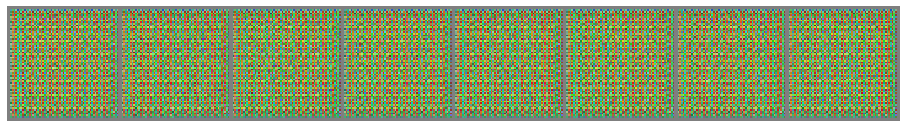

In [19]:
train(40,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load)